In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import spacy

In [3]:
df =pd.read_csv("/content/drive/MyDrive/NLP/example.csv")

In [4]:
filtered_df = df[df['entity_context'].apply(lambda x: x != '[]' and bool(x))]
filtered_df = filtered_df.reset_index(drop=True)

In [5]:
entity_context_data = filtered_df['entity_context']

In [7]:
entity_context_data.info()

<class 'pandas.core.series.Series'>
RangeIndex: 17767 entries, 0 to 17766
Series name: entity_context
Non-Null Count  Dtype 
--------------  ----- 
17767 non-null  object
dtypes: object(1)
memory usage: 138.9+ KB


In [8]:
dominance = pd.read_csv("/content/drive/MyDrive/NLP/dominance-NRC-VAD-Lexicon.txt", sep="\t", header=None, names=["word", "score"])

In [9]:
dominance

,word,score
0,powerful,0.991
1,leadership,0.983
2,success,0.981
3,govern,0.980
4,supreme,0.974
...,...,...
19966,vague,0.083
19967,penniless,0.083
19968,empty,0.081
19969,frail,0.069


In [10]:
dominance = dominance.dropna()

In [11]:
dominance.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19970 entries, 0 to 19970
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   word    19970 non-null  object 
 1   score   19970 non-null  float64
dtypes: float64(1), object(1)
memory usage: 468.0+ KB


In [12]:
dominance = dominance.reset_index(drop=True)

In [13]:
dominance_dict = dict(zip(dominance["word"], dominance["score"]))

In [14]:
nlp = spacy.load("en_core_web_sm")

In [15]:
entities_to_analyze = ["hamas", "israel"]
results = {"hamas": [], "israel": []}

In [16]:
def clean_text(text):
    cleaned_text = text.strip("[]").replace("'", "").strip()
    return cleaned_text

In [17]:
entity_context = [clean_text(entity) for entity in entity_context_data]

In [19]:
def analyze_dominance_dependency(text, entity, dominance_dict):
    doc = nlp(text)
    related_words = []

    for token in doc:
        if token.text.lower() == entity.lower():
            for child in token.children:
                if child.pos_ in ["VERB", "NOUN", "ADJ"]:
                    related_words.append(child.text)
            if token.head.pos_ in ["VERB", "NOUN", "ADJ"]:
                related_words.append(token.head.text)
            for sibling in token.conjuncts:
                if sibling.pos_ in ["VERB", "NOUN", "ADJ"]:
                    related_words.append(sibling.text)

    dominance_scores = [dominance_dict[word.lower()] for word in related_words if word.lower() in dominance_dict]

    avg_dominance = sum(dominance_scores) / len(dominance_scores) if dominance_scores else None

    return {
        "entity": entity,
        "related_words": related_words,
        "average_dominance": avg_dominance
    }

In [20]:
for text in entity_context:
  for entity in entities_to_analyze:
    result = analyze_dominance_dependency(text, entity, dominance_dict)
    if result["average_dominance"] is not None:
        results[entity].append(result["average_dominance"])

In [21]:
hamas_avg_dominance = sum(results["Hamas"]) / len(results["Hamas"]) if results["Hamas"] else 0
israel_avg_dominance = sum(results["Israel"]) / len(results["Israel"]) if results["Israel"] else 0

In [22]:
print(f"Average Dominance for Hamas: {hamas_avg_dominance}")
print(f"Average Dominance for Israel: {israel_avg_dominance}")

Average Dominance for Hamas: 0.5836764968848978
Average Dominance for Israel: 0.5788739515677069


In [23]:
if hamas_avg_dominance > israel_avg_dominance:
    print("Hamas is described as more dominant or powerful in the text.")
elif hamas_avg_dominance < israel_avg_dominance:
    print("Israel is described as more dominant or powerful in the text.")
else:
    print("Both entities are described with similar levels of dominance.")

Hamas is described as more dominant or powerful in the text.


In [26]:
def extract_surrounding_words(text, entity):
    doc = nlp(text)
    surrounding_words = []
    for token in doc:
        if token.text.lower() == entity.lower():
            surrounding_words.extend([child.text for child in token.children if child.pos_ in ["VERB", "NOUN", "ADJ"]])
            if token.head.pos_ in ["VERB", "NOUN", "ADJ"]:
                surrounding_words.append(token.head.text)
    return surrounding_words

In [24]:
entities = ["Hamas", "Israel"]

In [27]:
entity_words = {entity: [] for entity in entities}
for text in entity_context:
    for entity in entities:
        words = extract_surrounding_words(text, entity)
        entity_words[entity].extend(words)

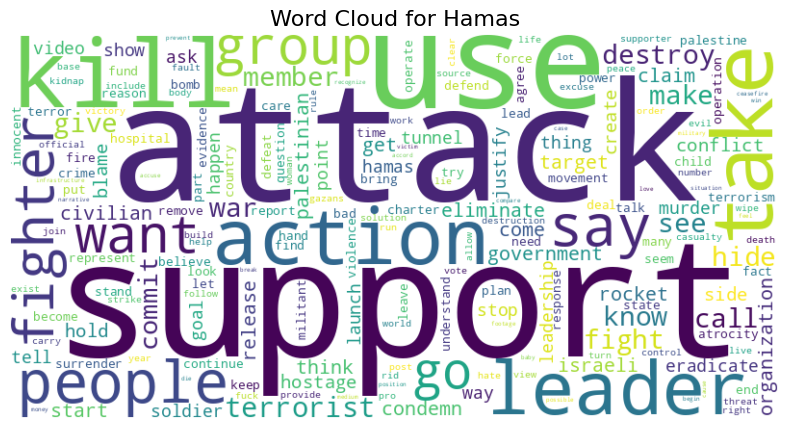

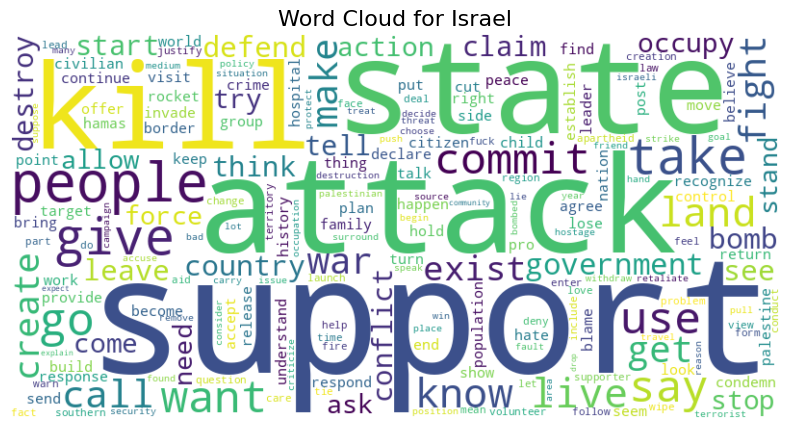

In [29]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
for entity, words in entity_words.items():
    word_freq = Counter(words)
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_freq)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for {entity}", fontsize=16)
    plt.show()